In [80]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

useDeng = False

if useDeng: images = glob.glob('*.bmp')
else: images = glob.glob('*.jpg')
patternSize = (11,12)
squareSize = 30
imgSize = (640,480)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [81]:
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize
    return X

boardPoints = construct3DPoints(patternSize,squareSize)
worldPoints = []
imagePoints = [] 

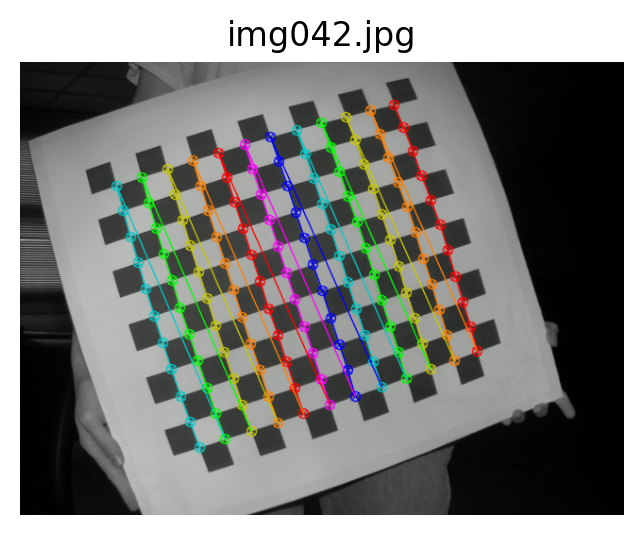

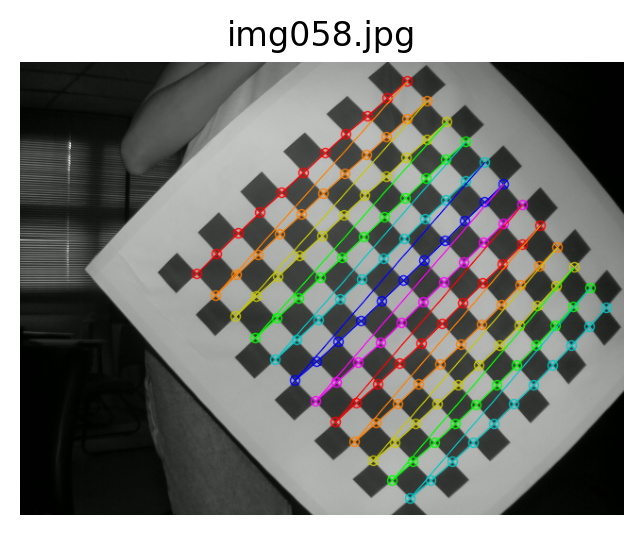

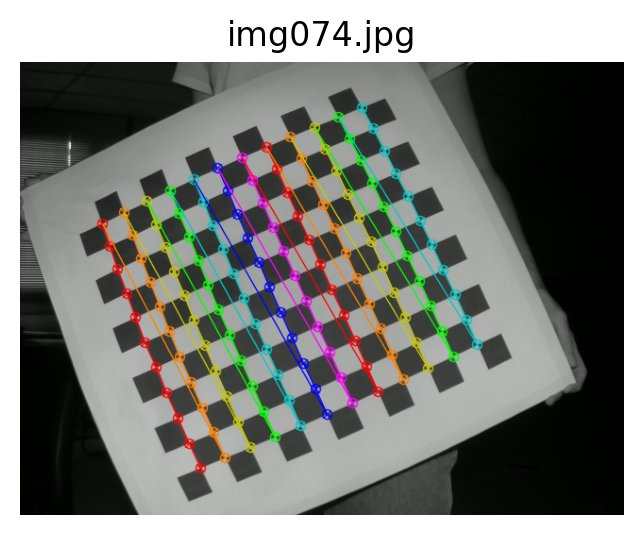

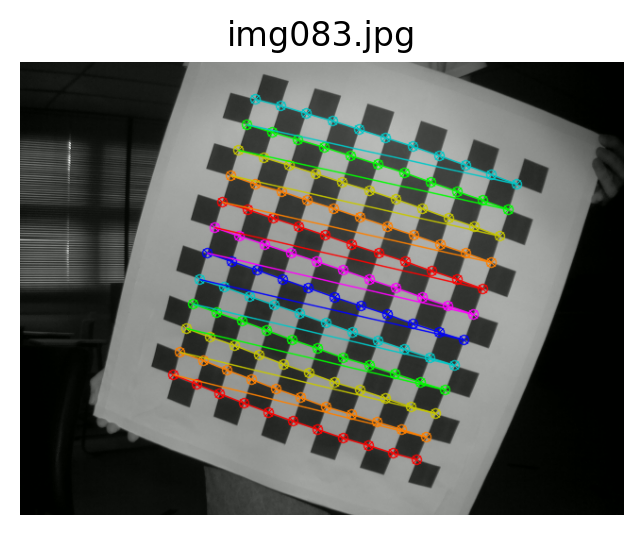

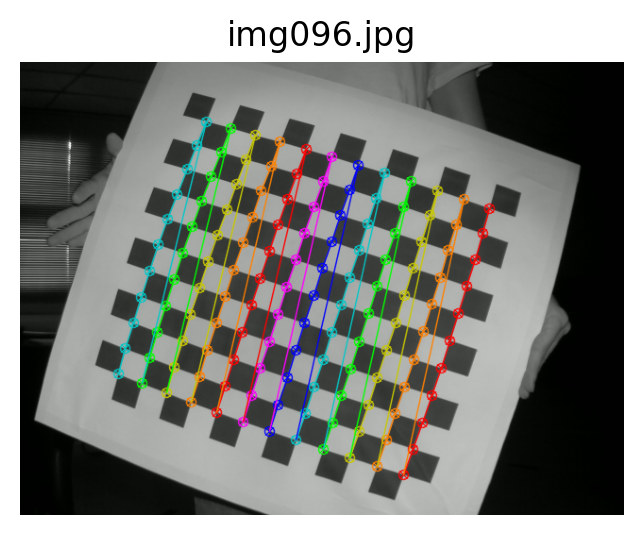

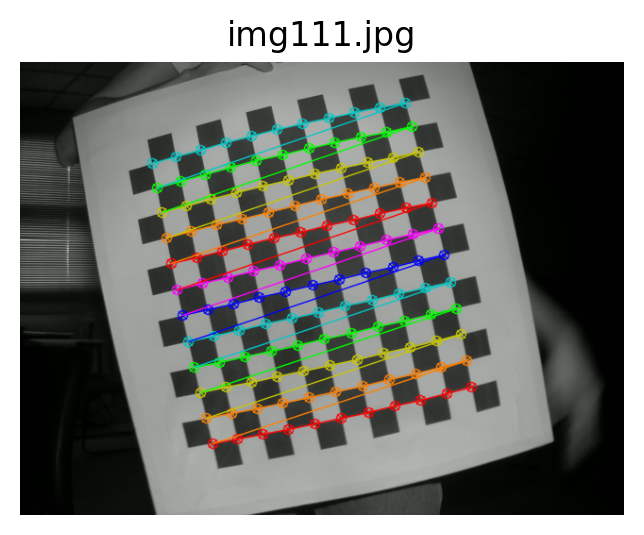

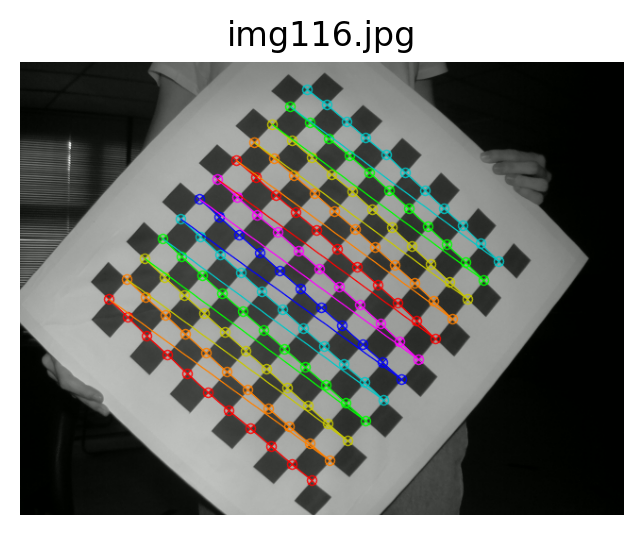

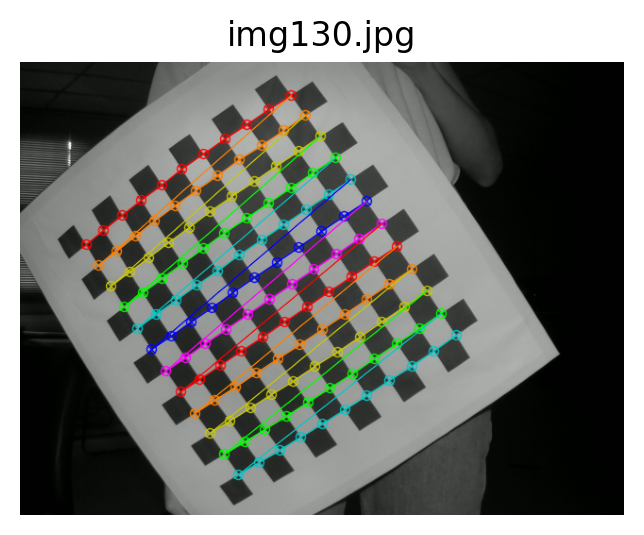

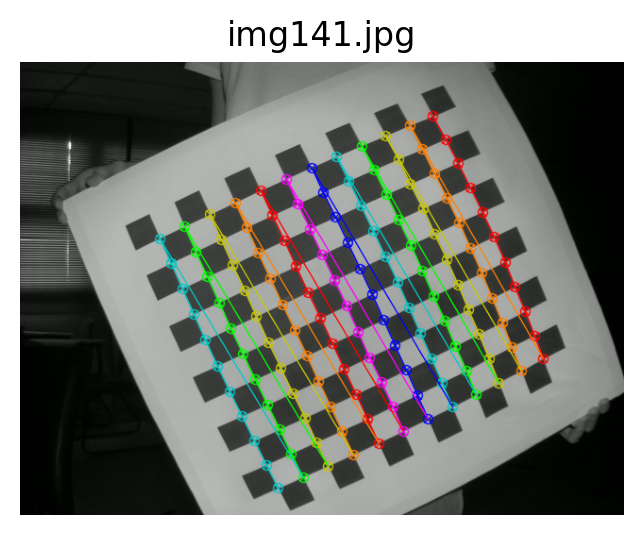

In [82]:
counter = 0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if ret == True:
        cornersRefined = cv2.cornerSubPix(gray, corners, (7,7), (-1,-1), criteria)
        imagePoints.append(cornersRefined)
        worldPoints.append(boardPoints)
        counter+=1
        cv2.drawChessboardCorners(img, patternSize, cornersRefined, ret)
        plt.figure(figsize=(4, 3), dpi=200)
        plt.imshow(img[:,:,::-1])
        plt.axis('off')
        plt.title(fname)
        cv2.imwrite(str(counter)+'Markers.png', img)

In [83]:
flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)
ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                            flags=flagsCalib,criteria=calibrateCriteria)
print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)

Using 9 of 9 images
RMS re-projection error: 0.4462983790425655
Camera Matrix:
 [[678.01961771   0.         304.08487861]
 [  0.         677.69079971 245.51546211]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[ -0.1051884 ]
 [ -0.43232778]
 [  4.32031973]
 [-10.56067646]]


In [84]:
def undistort(imgpath,K,D,DIM,axis,method,scale):
    img = cv2.imread(imgpath)
    DIM = img.shape[:2][::-1] 

    #new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, DIM, np.eye(3), balance=1)

    new_K = K.copy()
    new_K[0,0]=K[0,0]*scale
    new_K[1,1]=K[1,1]*scale
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    axs[axis].imshow(undistorted_img[:,:,::-1])
    axs[axis].axis('off')
    axs[axis].set_title('undistort')
    cv2.imwrite('undistort'+method+'.png', undistorted_img)

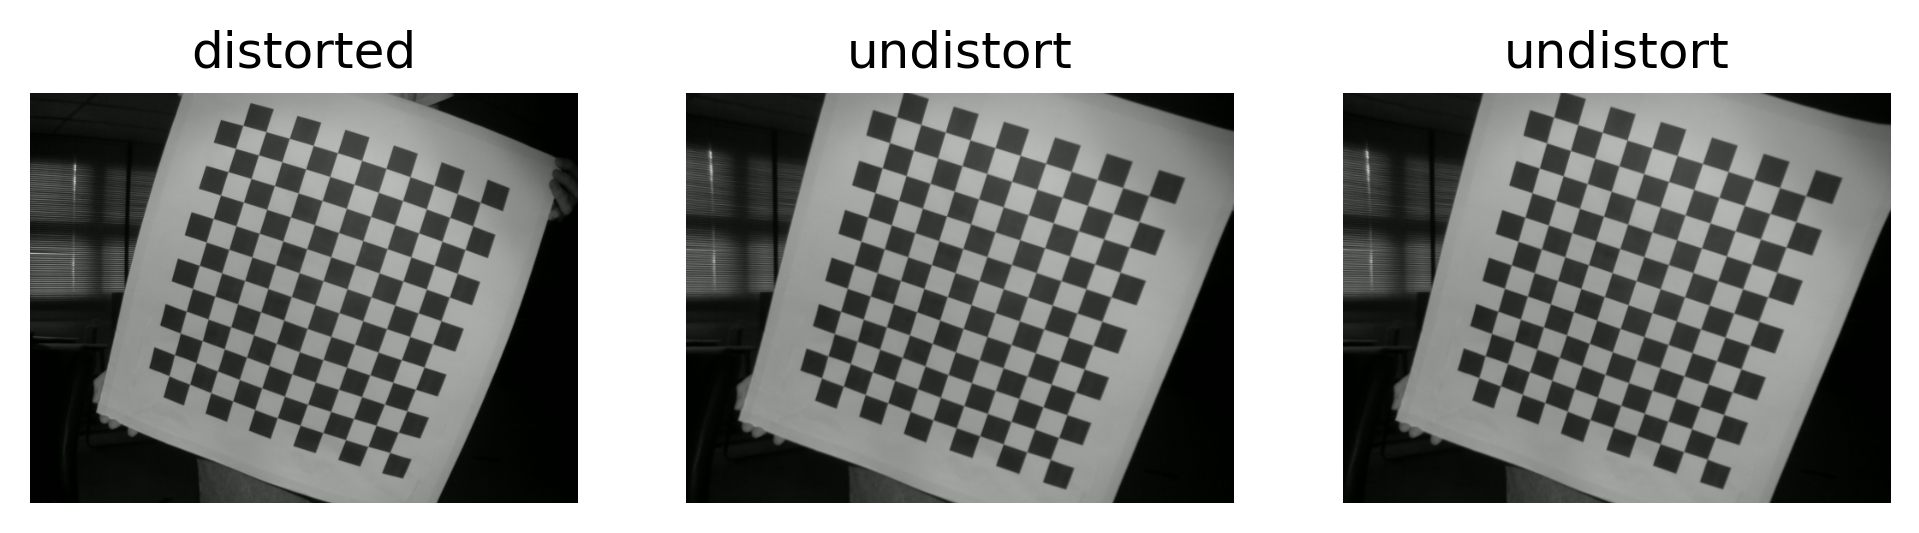

In [85]:
img = cv2.imread(images[3])

fig, axs = plt.subplots(1,3,figsize=(8, 2), dpi=300)
axs[0].imshow(img[:,:,::-1])
axs[0].axis('off')
axs[0].set_title('distorted')
cv2.imwrite('undistortNOriginal.png', img)

undistort(images[3],cameraMatrix,k,imgSize,1,'openCV',1)

if useDeng:
    k[0] = 0.2377
    k[1] = -0.3752
    k[2] = 6.6712
    k[3] = -27.4156
else:
    k[0] = 0
    k[1] = -2.14
    k[2] = 15;5
    k[3] =  -34
    cameraMatrix[0][0] = 672
    cameraMatrix[1][1] = 672
    cameraMatrix[0][2] = 304
    cameraMatrix[1][2] = 246

undistort(images[3],cameraMatrix,k,imgSize,2,'MATLAB',1)